Import necessary dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Load data

In [4]:
data = pd.read_csv('datasets/IoT_Modbus.csv')

Combine 'date' and 'time' into a single datetime column

In [5]:
data['date'] = data['date'].str.strip()
data['time'] = data['time'].str.strip()
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d-%b-%y %H:%M:%S')

Extract time features

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

Time series models need to ensure that the data set is arranged in time order

In [7]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

# Split the dataset (Sequential Split)

In [8]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Data preprocessing (Normalization)

In [9]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = StandardScaler()
X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229755 entries, 0 to 229754
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 9.6 MB


# Execution model
## Create model

In [10]:
class LightweightMLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_size):
        super(LightweightMLP, self).__init__()
        
        self.linear_1 = nn.Linear(input_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        temp = F.relu(self.linear_1(x))
        return self.linear_2(temp)

Initialize model

In [11]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1

model = LightweightMLP(features_num, hidden_neurons_num, output_neurons_num).to(device)

In [12]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

Build loss functions and optimizers

In [13]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor ([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

Construct Data Loader

In [14]:
batch_size = 128
X_train_tensor = torch.tensor(X_train.values).float().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

Training model

In [15]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    times = 0

    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate indicators
        model.eval()
        with torch.no_grad():
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float().cpu().numpy()

            # Calculate indicators
            y = labels.cpu().numpy()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy_score(y, predictions)
            times += 1
            
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = running_accuracy / times
    loss_list[epoch] = epoch_loss
    acc_list[epoch] = accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}')
    pbar.update(1)
pbar.reset()

  1%|          | 1/100 [00:02<03:23,  2.06s/it]

Epoch [1/100], Loss: 0.6586840281693845, Accuracy: 0.8317647470955907


  2%|▏         | 2/100 [00:03<03:10,  1.94s/it]

Epoch [2/100], Loss: 0.5343766392400632, Accuracy: 0.8409614769458975


  3%|▎         | 3/100 [00:05<03:04,  1.91s/it]

Epoch [3/100], Loss: 0.5067936137046537, Accuracy: 0.8473511065629459


  4%|▍         | 4/100 [00:07<03:02,  1.91s/it]

Epoch [4/100], Loss: 0.48771082973540414, Accuracy: 0.8606522960685735


  5%|▌         | 5/100 [00:09<03:01,  1.91s/it]

Epoch [5/100], Loss: 0.4746780942091913, Accuracy: 0.8759073448150917


  6%|▌         | 6/100 [00:11<03:01,  1.93s/it]

Epoch [6/100], Loss: 0.4636540068701607, Accuracy: 0.8899264980637273


  7%|▋         | 7/100 [00:13<02:57,  1.91s/it]

Epoch [7/100], Loss: 0.4537107988683208, Accuracy: 0.8990316512670699


  8%|▊         | 8/100 [00:15<03:04,  2.01s/it]

Epoch [8/100], Loss: 0.4456738967524112, Accuracy: 0.9041415078583237


  9%|▉         | 9/100 [00:17<03:05,  2.04s/it]

Epoch [9/100], Loss: 0.43879910762290675, Accuracy: 0.9078847209955387


 10%|█         | 10/100 [00:19<03:03,  2.04s/it]

Epoch [10/100], Loss: 0.4329533756612027, Accuracy: 0.9106965274475168


 11%|█         | 11/100 [00:21<03:01,  2.04s/it]

Epoch [11/100], Loss: 0.42813917038848054, Accuracy: 0.9127203784224472


 12%|█▏        | 12/100 [00:23<02:58,  2.03s/it]

Epoch [12/100], Loss: 0.42414919415813973, Accuracy: 0.9142088881717508


 13%|█▎        | 13/100 [00:25<02:54,  2.01s/it]

Epoch [13/100], Loss: 0.4207325921693265, Accuracy: 0.9154884842720293


 14%|█▍        | 14/100 [00:27<02:52,  2.00s/it]

Epoch [14/100], Loss: 0.4177588359835783, Accuracy: 0.9166157475032272


 15%|█▌        | 15/100 [00:30<02:58,  2.11s/it]

Epoch [15/100], Loss: 0.4151469986615577, Accuracy: 0.9174644592023915


 16%|█▌        | 16/100 [00:32<02:55,  2.08s/it]

Epoch [16/100], Loss: 0.4128343655970672, Accuracy: 0.9181825998709152


 17%|█▋        | 17/100 [00:34<02:47,  2.01s/it]

Epoch [17/100], Loss: 0.4107587245241664, Accuracy: 0.9188920358040629


 18%|█▊        | 18/100 [00:35<02:40,  1.96s/it]

Epoch [18/100], Loss: 0.4088752636492897, Accuracy: 0.9194056151912494


 19%|█▉        | 19/100 [00:37<02:35,  1.93s/it]

Epoch [19/100], Loss: 0.40713859482111525, Accuracy: 0.9199278993138121


 20%|██        | 20/100 [00:39<02:32,  1.90s/it]

Epoch [20/100], Loss: 0.40552680942052927, Accuracy: 0.9202717363611659


 21%|██        | 21/100 [00:41<02:29,  1.89s/it]

Epoch [21/100], Loss: 0.4040099316982109, Accuracy: 0.9207809633806645


 22%|██▏       | 22/100 [00:43<02:25,  1.87s/it]

Epoch [22/100], Loss: 0.40257352617009495, Accuracy: 0.9213293617093553


 23%|██▎       | 23/100 [00:45<02:23,  1.86s/it]

Epoch [23/100], Loss: 0.40123295564871586, Accuracy: 0.9217776555812216


 24%|██▍       | 24/100 [00:46<02:21,  1.86s/it]

Epoch [24/100], Loss: 0.40000361250675565, Accuracy: 0.9223521681160405


 25%|██▌       | 25/100 [00:48<02:19,  1.86s/it]

Epoch [25/100], Loss: 0.398862732477472, Accuracy: 0.9228528673256788


 26%|██▌       | 26/100 [00:50<02:17,  1.86s/it]

Epoch [26/100], Loss: 0.3977943774895067, Accuracy: 0.9232228185791608


 27%|██▋       | 27/100 [00:52<02:15,  1.86s/it]

Epoch [27/100], Loss: 0.39678444171887856, Accuracy: 0.9236101793033947


 28%|██▊       | 28/100 [00:54<02:13,  1.86s/it]

Epoch [28/100], Loss: 0.39583601953090825, Accuracy: 0.9240062447630047


 29%|██▉       | 29/100 [00:56<02:11,  1.86s/it]

Epoch [29/100], Loss: 0.3949366971158698, Accuracy: 0.924437129164119


 30%|███       | 30/100 [00:58<02:09,  1.85s/it]

Epoch [30/100], Loss: 0.39408314766680147, Accuracy: 0.9249289467128655


 31%|███       | 31/100 [00:59<02:07,  1.85s/it]

Epoch [31/100], Loss: 0.393268554526152, Accuracy: 0.9253337169078516


 32%|███▏      | 32/100 [01:01<02:05,  1.85s/it]

Epoch [32/100], Loss: 0.39249152420643785, Accuracy: 0.9257820107797179


 33%|███▎      | 33/100 [01:03<02:03,  1.84s/it]

Epoch [33/100], Loss: 0.39175800106275904, Accuracy: 0.9261040859886315


 34%|███▍      | 34/100 [01:05<02:01,  1.84s/it]

Epoch [34/100], Loss: 0.39105936597525776, Accuracy: 0.9265523798604978


 35%|███▌      | 35/100 [01:07<01:59,  1.84s/it]

Epoch [35/100], Loss: 0.39039200395238677, Accuracy: 0.9269440929524199


 36%|███▌      | 36/100 [01:09<01:57,  1.84s/it]

Epoch [36/100], Loss: 0.389758188098754, Accuracy: 0.9272487586905813


 37%|███▋      | 37/100 [01:10<01:55,  1.84s/it]

Epoch [37/100], Loss: 0.38915077377184415, Accuracy: 0.9276274146794393


 38%|███▊      | 38/100 [01:12<01:53,  1.83s/it]

Epoch [38/100], Loss: 0.38857083596025355, Accuracy: 0.9279277280499129


 39%|███▉      | 39/100 [01:14<01:51,  1.83s/it]

Epoch [39/100], Loss: 0.3880188517830078, Accuracy: 0.928197751772086


 40%|████      | 40/100 [01:16<01:49,  1.83s/it]

Epoch [40/100], Loss: 0.3874997894934286, Accuracy: 0.9284588938333673


 41%|████      | 41/100 [01:18<01:48,  1.84s/it]

Epoch [41/100], Loss: 0.3870074514967737, Accuracy: 0.9287417977330887


 42%|████▏     | 42/100 [01:20<01:46,  1.83s/it]

Epoch [42/100], Loss: 0.3865317242497996, Accuracy: 0.9289245971759857


 43%|████▎     | 43/100 [01:21<01:44,  1.83s/it]

Epoch [43/100], Loss: 0.38607492061066645, Accuracy: 0.9292031487080191


 44%|████▍     | 44/100 [01:23<01:43,  1.84s/it]

Epoch [44/100], Loss: 0.3856383314270394, Accuracy: 0.9294860526077406


 45%|████▌     | 45/100 [01:25<01:40,  1.84s/it]

Epoch [45/100], Loss: 0.3852255556308983, Accuracy: 0.9297167280952058


 46%|████▌     | 46/100 [01:27<01:39,  1.83s/it]

Epoch [46/100], Loss: 0.38483549983313975, Accuracy: 0.9299212893765428


 47%|████▋     | 47/100 [01:29<01:37,  1.83s/it]

Epoch [47/100], Loss: 0.3844691283681941, Accuracy: 0.9301476124963199


 48%|████▊     | 48/100 [01:31<01:35,  1.83s/it]

Epoch [48/100], Loss: 0.38412307293907305, Accuracy: 0.9303217072038409


 49%|████▉     | 49/100 [01:32<01:32,  1.82s/it]

Epoch [49/100], Loss: 0.38379743575883773, Accuracy: 0.9305045066467378


 50%|█████     | 50/100 [01:34<01:30,  1.81s/it]

Epoch [50/100], Loss: 0.3834843359188931, Accuracy: 0.9305959063681862


 51%|█████     | 51/100 [01:36<01:28,  1.81s/it]

Epoch [51/100], Loss: 0.38318815631113184, Accuracy: 0.930743886869579


 52%|█████▏    | 52/100 [01:38<01:26,  1.80s/it]

Epoch [52/100], Loss: 0.38290819826044326, Accuracy: 0.9308570484294676


 53%|█████▎    | 53/100 [01:40<01:24,  1.80s/it]

Epoch [53/100], Loss: 0.3826434802818095, Accuracy: 0.9310311431369885


 54%|█████▍    | 54/100 [01:41<01:22,  1.80s/it]

Epoch [54/100], Loss: 0.38238762335619964, Accuracy: 0.9311660665353172


 55%|█████▌    | 55/100 [01:43<01:20,  1.80s/it]

Epoch [55/100], Loss: 0.3821436861807087, Accuracy: 0.93131404703671


 56%|█████▌    | 56/100 [01:45<01:18,  1.79s/it]

Epoch [56/100], Loss: 0.381911943927584, Accuracy: 0.9314402656996627


 57%|█████▋    | 57/100 [01:47<01:17,  1.80s/it]

Epoch [57/100], Loss: 0.38169141377588833, Accuracy: 0.9315273130534231


 58%|█████▊    | 58/100 [01:49<01:17,  1.85s/it]

Epoch [58/100], Loss: 0.38148196698732, Accuracy: 0.9316230651425595


 59%|█████▉    | 59/100 [01:51<01:16,  1.86s/it]

Epoch [59/100], Loss: 0.38128339056026866, Accuracy: 0.9316968784677402


 60%|██████    | 60/100 [01:53<01:15,  1.89s/it]

Epoch [60/100], Loss: 0.3810968282540494, Accuracy: 0.9318230971306928


 61%|██████    | 61/100 [01:54<01:14,  1.90s/it]

Epoch [61/100], Loss: 0.3809194030089751, Accuracy: 0.931910321409969


 62%|██████▏   | 62/100 [01:56<01:11,  1.87s/it]

Epoch [62/100], Loss: 0.3807511618473525, Accuracy: 0.9320104258667935


 63%|██████▎   | 63/100 [01:58<01:08,  1.85s/it]

Epoch [63/100], Loss: 0.38059112444743426, Accuracy: 0.9320278353375456


 64%|██████▍   | 64/100 [02:00<01:06,  1.86s/it]

Epoch [64/100], Loss: 0.3804393823868131, Accuracy: 0.932110530323618


 65%|██████▌   | 65/100 [02:02<01:05,  1.86s/it]

Epoch [65/100], Loss: 0.3802964618902793, Accuracy: 0.9321758158389384


 66%|██████▌   | 66/100 [02:04<01:04,  1.89s/it]

Epoch [66/100], Loss: 0.3801623336114535, Accuracy: 0.9322454537219467


 67%|██████▋   | 67/100 [02:06<01:02,  1.89s/it]

Epoch [67/100], Loss: 0.38003591289899236, Accuracy: 0.9323150916049551


 68%|██████▊   | 68/100 [02:07<00:59,  1.87s/it]

Epoch [68/100], Loss: 0.3799145481003576, Accuracy: 0.9323455581787712


 69%|██████▉   | 69/100 [02:09<00:57,  1.85s/it]

Epoch [69/100], Loss: 0.37979940579211535, Accuracy: 0.9323455581787712


 70%|███████   | 70/100 [02:11<00:55,  1.84s/it]

Epoch [70/100], Loss: 0.3796909822238257, Accuracy: 0.9323586152818353


 71%|███████   | 71/100 [02:13<00:53,  1.84s/it]

Epoch [71/100], Loss: 0.379587121059481, Accuracy: 0.9323716723848994


 72%|███████▏  | 72/100 [02:15<00:51,  1.83s/it]

Epoch [72/100], Loss: 0.37948867924760643, Accuracy: 0.9324108436940916


 73%|███████▎  | 73/100 [02:17<00:49,  1.83s/it]

Epoch [73/100], Loss: 0.37939528973405423, Accuracy: 0.9324326055325317


 74%|███████▍  | 74/100 [02:18<00:47,  1.82s/it]

Epoch [74/100], Loss: 0.3793062913179403, Accuracy: 0.9324543673709718


 75%|███████▌  | 75/100 [02:20<00:45,  1.82s/it]

Epoch [75/100], Loss: 0.3792213665465168, Accuracy: 0.9324717768417239


 76%|███████▌  | 76/100 [02:22<00:43,  1.82s/it]

Epoch [76/100], Loss: 0.3791383103335561, Accuracy: 0.9325196528862921


 77%|███████▋  | 77/100 [02:24<00:42,  1.83s/it]

Epoch [77/100], Loss: 0.37905522747108905, Accuracy: 0.932484833944788


 78%|███████▊  | 78/100 [02:26<00:40,  1.83s/it]

Epoch [78/100], Loss: 0.3789773078015994, Accuracy: 0.932497891047852


 79%|███████▉  | 79/100 [02:27<00:38,  1.82s/it]

Epoch [79/100], Loss: 0.3789041233476271, Accuracy: 0.9325196528862921


 80%|████████  | 80/100 [02:29<00:36,  1.82s/it]

Epoch [80/100], Loss: 0.37883816694829886, Accuracy: 0.932506595783228


 81%|████████  | 81/100 [02:31<00:34,  1.81s/it]

Epoch [81/100], Loss: 0.3787786655546815, Accuracy: 0.9325327099893562


 82%|████████▏ | 82/100 [02:33<00:32,  1.80s/it]

Epoch [82/100], Loss: 0.3787232354679283, Accuracy: 0.9325153005186041


 83%|████████▎ | 83/100 [02:35<00:30,  1.80s/it]

Epoch [83/100], Loss: 0.37867331681491545, Accuracy: 0.9325283576216682


 84%|████████▍ | 84/100 [02:36<00:28,  1.79s/it]

Epoch [84/100], Loss: 0.3786277182070916, Accuracy: 0.9325414147247323


 85%|████████▌ | 85/100 [02:38<00:26,  1.79s/it]

Epoch [85/100], Loss: 0.3785865552303298, Accuracy: 0.9325849384016125


 86%|████████▌ | 86/100 [02:40<00:25,  1.79s/it]

Epoch [86/100], Loss: 0.378550490237759, Accuracy: 0.9325805860339245


 87%|████████▋ | 87/100 [02:42<00:23,  1.79s/it]

Epoch [87/100], Loss: 0.3785176682311644, Accuracy: 0.9325718812985484


 88%|████████▊ | 88/100 [02:44<00:21,  1.79s/it]

Epoch [88/100], Loss: 0.3784875756150498, Accuracy: 0.9325588241954843


 89%|████████▉ | 89/100 [02:45<00:19,  1.79s/it]

Epoch [89/100], Loss: 0.37846106680074465, Accuracy: 0.9325544718277963


 90%|█████████ | 90/100 [02:47<00:17,  1.79s/it]

Epoch [90/100], Loss: 0.3784352695545521, Accuracy: 0.9325936431369884


 91%|█████████ | 91/100 [02:49<00:16,  1.79s/it]

Epoch [91/100], Loss: 0.37841148079109643, Accuracy: 0.9325544718277963


 92%|█████████▏| 92/100 [02:51<00:14,  1.79s/it]

Epoch [92/100], Loss: 0.3783892133437454, Accuracy: 0.9325805860339245


 93%|█████████▎| 93/100 [02:53<00:12,  1.78s/it]

Epoch [93/100], Loss: 0.3783688978314444, Accuracy: 0.9326023478723645


 94%|█████████▍| 94/100 [02:54<00:10,  1.78s/it]

Epoch [94/100], Loss: 0.3783500886354396, Accuracy: 0.9325979955046765


 95%|█████████▌| 95/100 [02:56<00:08,  1.78s/it]

Epoch [95/100], Loss: 0.3783327580918654, Accuracy: 0.9325675289308604


 96%|█████████▌| 96/100 [02:58<00:07,  1.79s/it]

Epoch [96/100], Loss: 0.37831589367137464, Accuracy: 0.9325936431369884


 97%|█████████▋| 97/100 [03:00<00:05,  1.79s/it]

Epoch [97/100], Loss: 0.3783013748637751, Accuracy: 0.9326067002400525


 98%|█████████▊| 98/100 [03:01<00:03,  1.79s/it]

Epoch [98/100], Loss: 0.3782877376917716, Accuracy: 0.9326371668138688


 99%|█████████▉| 99/100 [03:03<00:01,  1.79s/it]

Epoch [99/100], Loss: 0.37827479588783347, Accuracy: 0.9326284620784927


  0%|          | 0/100 [00:00<?, ?it/s]          

Epoch [100/100], Loss: 0.37826274201150367, Accuracy: 0.9326110526077406


Visualizing the training process

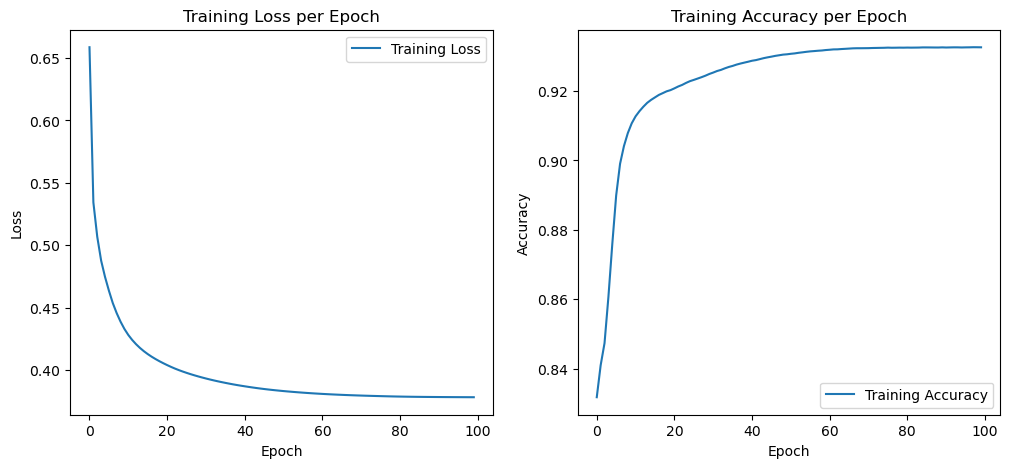

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Unseen test set performance

In [17]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs).squeeze()
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.9126725743832588 , Precision:  0.8851063829787233 , Recall:  0.4206268958543984 , F1:  0.5702535983550377


Save model

In [18]:
save_folder = "save_model"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"model_mlp_{current_time}.pt"
full_path = os.path.join(save_folder, model_filename)
# torch.save(model.state_dict(), full_path)

print("Model saved as:", full_path)

Model saved as: save_model/model_mlp_2023-11-23_11-20-30.pt
